# README

This is the best algorithm we have using the biexponential model for 6 parameters. 

Steps:
    1. Each curve is evaluated as biexponential or monoexponential using the BIC --> we use the wikipedia version
    2. We first take the data, fit it twice to the biexponential model with unique initial starting locations with scipy.curve_fit
    3. We use the estimated parameters from curve_fit as new initial conditions in the new moX vs. biX objective function



We are playing with code that would take data from the brain and assess if each point is MoX or BiX. The objective function used to select parameters will then ensure that the MoX points are fit with the MoX function while the biX points are fit with the biX function. This file looks at the 6p model across a log scale of TI value 

There are two important functions here
1: the function that evaluates data as biX or moX --> returns a list of biX or moX
2: the objective function equation

# Libraries

In [67]:
#Preparing all libraries
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.optimize import curve_fit
from scipy.optimize import minimize
import addcopyfighandler
import statistics
import math
import time
from tqdm import trange
from matplotlib import cm
import colorsys
from datetime import date
import pickle
import functools

# Initialize Parameters

In [68]:
####### Options #######
randStart = True                  #Initial guess for parameter values in random locations

In [69]:
######All Fixed parameters for code
#Parameters held constant
T11 = 600
T12 = 1200
c1 = 0.4
c2 = 0.6 
T21 = 40
T22 = 100

true_params = np.array([T11, T12, c1, c2, T21, T22])

#Building the TE array - this should be a uniform array
n_points = 64
TE_step = 8

TE_DATA = np.linspace(TE_step, TE_step*n_points, n_points) #ms units

assert(TE_DATA[-1] == 512)
d_TE = np.mean(np.diff(TE_DATA))
assert(d_TE == 8)

TI1star = np.log(2)*T11
TI2star = np.log(2)*T12


######### TI list of points used in the final evaluation
TI_DATA = np.array([0, 200, 400, 600, 800, 1000, 1200, 1400])#np.logspace(1,3.5,10)#np.array([0, 550, 700])#

#SNR Value to Evaluate
SNR_value = 100

#Parameters that dictate process related features
var_reps = 1000          #number of times we iterate the full test

#number of multistarts in the BIC filter to ensure accurate measurement
multi_starts_BIC = 3

if randStart:
    multi_starts_obj = 2
else:
    multi_starts_obj = 1

#number of iterations to evaluate consistency of BIC filter
BIC_eval_iter = 100     

#Builds a string of parameters to use in the titles
ParamTitle_6p = [r'$T_{11}$', r'$T_{12}$', r'$c_1$', r'$c_2$', r'$T_{21}$', r'$T_{22}$']
round_Params = [round(num, 2) for num in true_params]
pList = ', '.join(str(x) for x in round_Params)
pTitleList = ', '.join(x for x in ParamTitle_6p) #Builds the list of parametes used to generate the original data

#### Important for Naming
date = date.today()
day = date.strftime('%d')
month = date.strftime('%B')[0:3]
year = date.strftime('%y')

In [70]:
#Defining the function of interest

def S_biX_6p(TE, T11, T12, c1, c2, T21, T22, TI = 0):
    exp1 = c1*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    exp2 = c2*(1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    return exp1 + exp2

#The ravel structure necessary for the curve_fit algorithm
def S_biX_6p_ravel(T_dat, T11, T12, c1, c2, T21, T22):
    TE, TI = T_dat
    exp1 = c1*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    exp2 = c2*(1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    return exp1 + exp2

def calculate_RSS_TI(func, popt, TI_val, data):
    est_curve = func(TE_DATA, *popt, TI = TI_val)
    RSS = np.sum((est_curve - data)**2)
    
    return RSS

def S_moX_3p(TE, T1, c, T2, TI = 0):
    return c*(1-2*np.exp(-TI/T1))*np.exp(-TE/T2)

#The one dimensional models are used to evaluate if a curve is more likely monoX or biX
def S_biX_4p(TE, d1, d2, T21, T22):
    exp1 = d1*np.exp(-TE/T21)
    exp2 = d2*np.exp(-TE/T22)
    return exp1 + exp2

def S_moX_2p(TE, d, T2):
    return d*np.exp(-TE/T2)

#All curves get noise according to this equation
def add_noise(data, SNR):
    #returns a noised vector of data using the SNR given
    sigma = (c1+c2)/SNR #np.max(np.abs(data))/SNR
    noise = np.random.normal(0,sigma,data.shape)
    noised_data = data + noise
    return noised_data

In [71]:
def get_func_bounds(func):
    f_name = func.__name__
    if f_name == "S_biX_6p":
        lower_bound = (2, 2, 0, 0, 2, 2)
        upper_bound = (2000, 2000, 1, 1, 150, 150)
    elif f_name == "S_moX_3p":
        lower_bound = (2, 0, 2)
        upper_bound = (2000, 1, 150)
    elif f_name == "S_biX_4p":
        lower_bound = (-1, -1, 2, 2)
        upper_bound = (1, 1, 150, 150)
    elif f_name == "S_moX_2p":
        lower_bound = (-1, 2)
        upper_bound = (1, 150)
    else:
        raise Exception("Not a valid function: " + f_name)

    return lower_bound, upper_bound

def get_param_list(func):
    f_name = func.__name__
    if f_name.find("S_biX_6p") > -1:
        params = ("T21","T22","c1","c2","T21","T22")
    elif f_name.find("S_moX_3p") > -1:
        params = ("T21","c","T2")
    else:
        raise Exception("Not a valid function: " + f_name)

    return params

def set_p0(func, random = True):
    true_params = [T11, T12, c1, c2, T21, T22]
    if random:
        lb, ub = get_func_bounds(func)
        if func.__name__.find("S_biX_6p") > -1:
            T11_est = np.random.uniform(lb[-6],ub[-6])
            T12_est = np.random.uniform(T11_est,ub[-5])
            c1_est = np.random.uniform(lb[-4],ub[-4])
            T21_est = np.random.uniform(lb[-2],ub[-2])
            T22_est = np.random.uniform(T21_est,ub[-1])
            p0 = [T11_est, T12_est, c1_est, 1-c1_est, T21_est, T22_est]
        else:
            p0 = [np.random.uniform(lb[i],ub[i]) for i in range(len(lb))]
    else:
        # f_name = func.__name__
        # if f_name.find("moX") > -1:
        #     p0 = [75, 0.5, 75]
        # elif f_name.find("biX") > -1:
        #     p0 = [75, 75, 0.5, 0.5, 75, 75]
        # else:
        p0 = true_params
            
    return p0

def check_param_order(popt):
    #Reshaping of array to ensure that the parameter pairs all end up in the appropriate place - ensures that T22 > T21
    if (popt[-1] < popt[-2]): #We want by convention to make sure that T21 is <= T22
        for pi in range(np.size(popt)//2):
            p_hold = popt[2*pi]
            popt[2*pi] = popt[2*pi+1]
            popt[2*pi+1] = p_hold
    return popt

def calculate_RSS_TI(func, popt, TI_val, data):
    est_curve = func(TE_DATA, *popt, TI = TI_val)
    RSS = np.sum((est_curve - data)**2)
    
    return RSS

def calculate_RSS(func, popt, data):
    est_curve = func(TE_DATA, *popt)
    RSS = np.sum((est_curve - data)**2)
    
    return RSS

def estP_oneCurve(func, noisey_data):

    init_p = set_p0(func, random = True)
    lb, ub = get_func_bounds(func)

    popt, _ = curve_fit(func, TE_DATA, noisey_data, p0 = init_p, bounds = [lb,ub], method = 'trf', maxfev = 1500)
    popt = check_param_order(popt)
    RSS = calculate_RSS(func, popt, noisey_data)

    return popt, RSS

In [72]:
def BIC_opt1(RSS, TE_array, p_list, sigma):

    BIC = 1/len(TE_array) * (RSS + np.log(len(TE_array))*len(p_list)*(sigma)**2)

    return BIC

def BIC_opt2(RSS, TE_array, p_list):

    BIC = len(TE_array) * np.log(RSS/len(TE_array)) + len(p_list) * np.log(len(TE_array))

    return BIC

def evaluate_model(data, ms_iter = multi_starts_BIC):

    #Returns true if the moX is better than the biX --> returns a 1 for moX and a 0 for biX
    #Returns the parameters of the correct answer

    RSS_biX = np.inf
    RSS_moX = np.inf

    for ms in range(ms_iter):
        popt_biX_temp, RSS_biX_temp = estP_oneCurve(S_biX_4p, data)
        popt_moX_temp, RSS_moX_temp = estP_oneCurve(S_moX_2p, data)

        if RSS_biX_temp < RSS_biX:
            popt_biX = popt_biX_temp
            RSS_biX = RSS_biX_temp

        if RSS_moX_temp < RSS_moX:
            popt_moX = popt_moX_temp
            RSS_moX = RSS_moX_temp

    # popt_biX, RSS_biX = estP_oneCurve(S_biX_4p, data)
    # popt_moX, RSS_moX = estP_oneCurve(S_moX_2p, data)

    BIC_biX = BIC_opt1(RSS_biX, TE_DATA, popt_biX, 1/SNR_value)
    BIC_moX = BIC_opt1(RSS_moX, TE_DATA, popt_moX, 1/SNR_value)

    if BIC_moX < BIC_biX:
        return True, popt_moX, RSS_moX
    else:
        return False, popt_biX, RSS_biX


In [73]:
def objective_func_hc(param_est, data_2d, TI_array):

    curve_RSS = 0

    curve_RSS += calculate_RSS_TI(S_biX_6p, param_est, TI_array[0], data_2d[0,:])
    curve_RSS += calculate_RSS_TI(S_moX_3p, [param_est[-5], param_est[-3], param_est[-1]], TI_array[1], data_2d[1,:])
    curve_RSS += calculate_RSS_TI(S_moX_3p, [param_est[-6], param_est[-4], param_est[-2]], TI_array[2], data_2d[2,:])

    return curve_RSS

def conven_objective_func_hc(param_est, data_2d, TI_array):

    curve_RSS = 0

    curve_RSS += calculate_RSS_TI(S_biX_6p, param_est, TI_array[0], data_2d[0,:])
    curve_RSS += calculate_RSS_TI(S_biX_6p, param_est, TI_array[1], data_2d[1,:])
    curve_RSS += calculate_RSS_TI(S_biX_6p, param_est, TI_array[2], data_2d[2,:])

    return curve_RSS

def list_objective_func(param_est, data_2d, TI_array, X_list):
    assert(data_2d.shape[0] == len(TI_array))
    assert(len(X_list) == len(TI_array))

    curve_RSS = 0

    X_truth = [elem == "BiX" for elem in X_list]

    for iter in range(len(X_truth)):
        if X_truth[iter]:
            RSS_add = calculate_RSS_TI(S_biX_6p, param_est, TI_array[iter], data_2d[iter,:])
        else:
            if data_2d[iter,0] < 0:
                #first null point -> that means that only the long parameters with the two are used
                RSS_add = calculate_RSS_TI(S_moX_3p, [param_est[-5], param_est[-3], param_est[-1]], TI_array[iter], data_2d[iter,:])
            else:
                #second null point -> that means that only the short parameters with the two are used
                RSS_add = calculate_RSS_TI(S_moX_3p, [param_est[-6], param_est[-4], param_est[-2]], TI_array[iter], data_2d[iter,:])

        curve_RSS += RSS_add

    return curve_RSS

def RSS_obj_func(popt, data, TI_val, func):
    est_curve = func(TE_DATA, *popt, TI = TI_val)
    RSS = np.sum((est_curve - data)**2)
    
    return RSS


In [74]:
def calc_MSE(paramStore, true_params, clipped = False):
    varMat = np.var(paramStore, axis=0)
    biMat = np.mean(paramStore, axis = 0) - true_params  #E[p_hat] - p_true
    MSEMat = varMat + biMat**2
    if clipped:
        return MSEMat[-4:], biMat[-4:], varMat[-4:]
    return MSEMat, varMat, biMat

# Data Processing

In [75]:
data1 = S_biX_6p(TE_DATA, *true_params, TI = TI_DATA[0])
data2 = S_biX_6p(TE_DATA, *true_params, TI = TI_DATA[len(TI_DATA)//2])
data3 = S_biX_6p(TE_DATA, *true_params, TI = TI_DATA[-1])

sample_data = np.stack((data1, data2, data3), axis = 0)

noised_sample_data = add_noise(sample_data, SNR_value)

assert(noised_sample_data.shape[0] == 3)

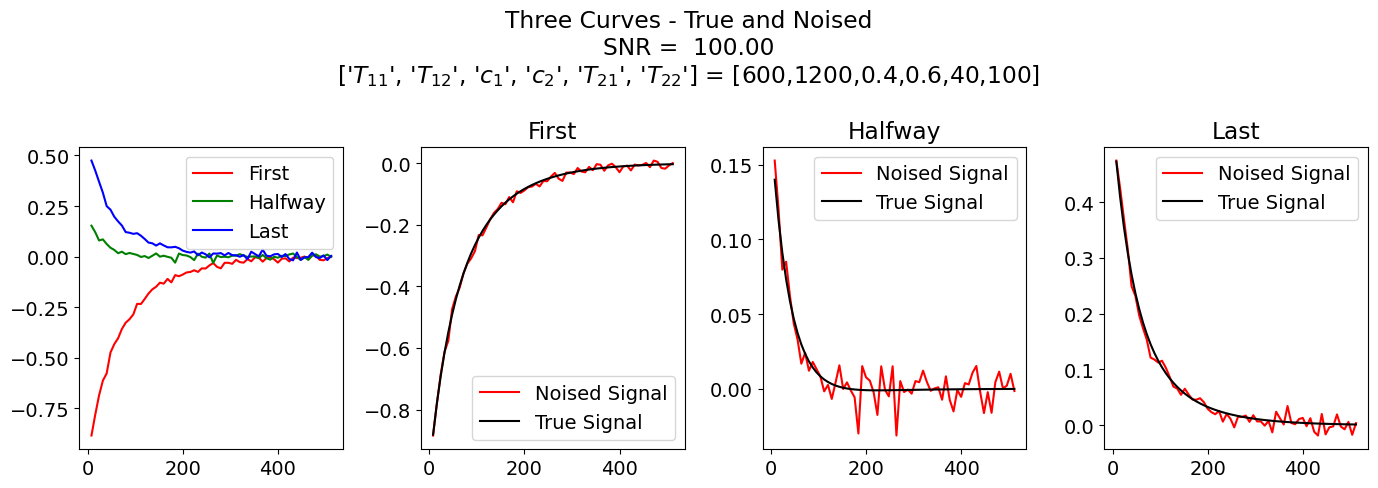

In [76]:
fig, ax = plt.subplots(1,4, figsize=(14,5), tight_layout=True)
fig.suptitle(f"Three Curves - True and Noised\nSNR = {SNR_value : 0.2f}\n{ParamTitle_6p} = [{T11},{T12},{c1},{c2},{T21},{T22}]")

ax[0].plot(TE_DATA, noised_sample_data[0,:], color = 'r', label = 'First')
ax[0].plot(TE_DATA, noised_sample_data[1,:], color = 'g', label = 'Halfway')
ax[0].plot(TE_DATA, noised_sample_data[2,:], color = 'b', label = 'Last')
ax[0].legend()

title_array = ['First','Halfway','Last']
for i in range(3):
    ax[i+1].plot(TE_DATA, noised_sample_data[i,:], color = 'r', label = 'Noised Signal')
    ax[i+1].plot(TE_DATA, sample_data[i,:], color = 'k', label = 'True Signal')
    ax[i+1].legend()
    ax[i+1].set_title(title_array[i])

# Iterative Fitting

In [77]:
signal_array = np.zeros([len(TI_DATA), len(TE_DATA)])

for iTI in range(len(TI_DATA)):
    signal_array[iTI,:] = S_biX_6p(TE_DATA, *true_params, TI = TI_DATA[iTI])

In [78]:
init_freq = np.zeros(len(TI_DATA))
for iter in trange(BIC_eval_iter):

    temp_noised_data = add_noise(signal_array, SNR_value)

    for iTI in range(len(TI_DATA)):
        mox_opt_iter, _, _ = evaluate_model(temp_noised_data[iTI,:])
        init_freq[iTI] += mox_opt_iter

100%|██████████| 100/100 [00:33<00:00,  2.99it/s]


In [79]:
print(f"Initial moX Frequencies")
print(f"True Parameters = {true_params}")
print(f"SNR = {SNR_value}")

for iTI in range(len(TI_DATA)):
    print(f"\nMonoexponential Frequency for TI = {TI_DATA[iTI]}")
    print(f"Monoexponential {init_freq[iTI]} times of {BIC_eval_iter}")
    print(f"Biexponential {BIC_eval_iter - init_freq[iTI]} times of {BIC_eval_iter}")

Initial moX Frequencies
True Parameters = [6.0e+02 1.2e+03 4.0e-01 6.0e-01 4.0e+01 1.0e+02]
SNR = 100

Monoexponential Frequency for TI = 0
Monoexponential 0.0 times of 100
Biexponential 100.0 times of 100

Monoexponential Frequency for TI = 200
Monoexponential 20.0 times of 100
Biexponential 80.0 times of 100

Monoexponential Frequency for TI = 400
Monoexponential 100.0 times of 100
Biexponential 0.0 times of 100

Monoexponential Frequency for TI = 600
Monoexponential 8.0 times of 100
Biexponential 92.0 times of 100

Monoexponential Frequency for TI = 800
Monoexponential 96.0 times of 100
Biexponential 4.0 times of 100

Monoexponential Frequency for TI = 1000
Monoexponential 60.0 times of 100
Biexponential 40.0 times of 100

Monoexponential Frequency for TI = 1200
Monoexponential 18.0 times of 100
Biexponential 82.0 times of 100

Monoexponential Frequency for TI = 1400
Monoexponential 2.0 times of 100
Biexponential 98.0 times of 100


In [80]:
param_est_BIC = np.zeros((var_reps, len(true_params)))
n_evals_BIC = np.zeros(var_reps)
fval_BIC = np.zeros(var_reps)
nfev_BIC = np.zeros(var_reps)

param_est_cvn = np.zeros((var_reps, len(true_params)))
n_evals_cvn = np.zeros(var_reps)
fval_cvn = np.zeros(var_reps)
nfev_cvn = np.zeros(var_reps)

param_est_cF = np.zeros((var_reps, len(true_params)))
fval_cF = np.zeros(var_reps)

#reshaping the bounds for the minimization function
lb, ub = get_func_bounds(S_biX_6p)
bnd_cat = [lb,ub]
bnd_cat = np.array(bnd_cat)
bnd_cat = np.transpose(bnd_cat)
bnds = bnd_cat.tolist()

#Collect the frequency of BIC assessments moX
BIC_moXassessments = np.zeros(len(TI_DATA))

#Building the ravel arrays for the curve_fit comparison
mTE, mTI = np.meshgrid(TE_DATA, TI_DATA)

vecT = np.vstack((mTE.ravel(), mTI.ravel())) #flattens the data points

curve_options = ["BiX", "MoX"] #This implies that a truth for evaluate is moX and a false is biX

print(f"Running {var_reps} noisy realization with {multi_starts_obj} multi start locations for each noisy realization")

for rep in trange(var_reps):

    noised_data = add_noise(signal_array, SNR_value)

    list_curve_BIC = []
    list_curve_cvn = []

    for iter in range(noised_data.shape[0]):
        mox_opt_iter, _, _ = evaluate_model(noised_data[iter,:])
        BIC_moXassessments[iter] += mox_opt_iter
        list_curve_BIC.append(curve_options[mox_opt_iter])
        list_curve_cvn.append(curve_options[0])

    cF_fval = np.inf

    for ms_iter in range(multi_starts_obj):
        init_p = set_p0(S_biX_6p, random = randStart)
        
        try:
            vecS = noised_data.ravel()
            popt_temp, _ = curve_fit(S_biX_6p_ravel, vecT, vecS, p0 = init_p, bounds = [lb, ub], method = 'trf', maxfev = 5000)
            RSS_cF_array = []
            for iter in range(noised_data.shape[0]):
                RSS_cF_array.append(calculate_RSS_TI(S_biX_6p, popt_temp, TI_DATA[iter], noised_data[iter,:]))
            RSS_cF_temp = np.sum(RSS_cF_array)
            if RSS_cF_temp < cF_fval:
                popt = popt_temp
                RSS_cF = RSS_cF_temp
                cF_fval = RSS_cF_temp
        except:
            print("No Optimum found")

    res_BIC = minimize(list_objective_func, popt, args = (noised_data, TI_DATA, list_curve_BIC), method = 'Nelder-Mead', bounds = bnds, options = {'maxiter': 4000, 'disp': False})
    
    res_cvn = minimize(list_objective_func, popt, args = (noised_data, TI_DATA, list_curve_cvn), method = 'Nelder-Mead', bounds = bnds, options = {'maxiter': 4000, 'disp': False})

    #Pulling relevant BIC objective function parts
    param_est_BIC[rep,:] = check_param_order(res_BIC.x)
    n_evals_BIC[rep] = res_BIC.nit
    fval_BIC[rep] = res_BIC.fun
    nfev_BIC[rep] = res_BIC.nfev

    #Pulling relevant cvn objective function parts
    param_est_cvn[rep,:] = check_param_order(res_cvn.x)
    n_evals_cvn[rep] = res_cvn.nit
    fval_cvn[rep] = res_cvn.fun
    nfev_cvn[rep] = res_cvn.nfev

    #Pulling relevant cF objective function parts
    param_est_cF[rep,:] = check_param_order(popt)
    fval_cF[rep] = RSS_cF


Running 1000 noisy realization with 2 multi start locations for each noisy realization


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [09:16<00:00,  1.80it/s]


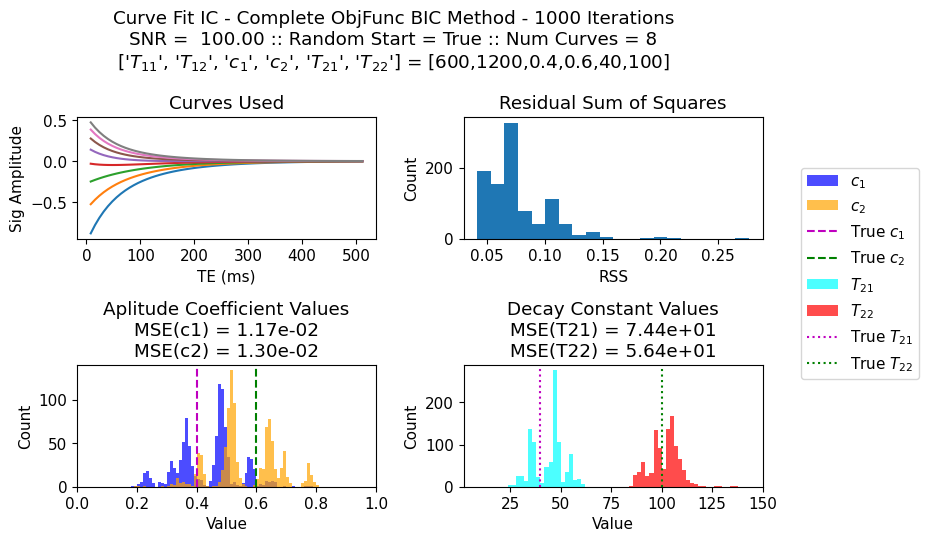

In [81]:
plt.rc('font', size = 11)

fig, ax = plt.subplots(2, 2, figsize=(8,5.5), tight_layout=True)
fig.suptitle(f"Curve Fit IC - Complete ObjFunc BIC Method - {var_reps} Iterations\nSNR = {SNR_value : 0.2f} :: Random Start = {randStart} :: Num Curves = {len(TI_DATA)}\n{ParamTitle_6p} = [{T11},{T12},{c1},{c2},{T21},{T22}]")

labels = get_param_list(S_biX_6p)
lb, ub = get_func_bounds(S_biX_6p)

MSEMat, varMat, sqBMat = calc_MSE(param_est_BIC, true_params)

for ii in range(signal_array.shape[0]):
    ax[0,0].plot(TE_DATA, signal_array[ii,:])
# ax[0,0].legend()
ax[0,0].set_xlabel("TE (ms)")
ax[0,0].set_ylabel("Sig Amplitude")
ax[0,0].set_title("Curves Used")

ax[0,1].hist(x = fval_BIC, bins = 20)
ax[0,1].set_xlabel('RSS')
ax[0,1].set_ylabel('Count')
ax[0,1].set_title("Residual Sum of Squares")

bin_array = np.arange(0, 1, 0.01)
ax[1,0].hist(x=param_est_BIC[:,-4], bins=bin_array, color='b', label = r'$c_{1}$', alpha = 0.7)
ax[1,0].hist(x=param_est_BIC[:,-3], bins=bin_array, color='orange', label = r'$c_{2}$', alpha = 0.7)
ax[1,0].axvline(x = true_params[-4], label = r'True $c_{1}$', color='m', ls = '--')
ax[1,0].axvline(x = true_params[-3], label = r'True $c_{2}$', color='g', ls = '--')
# ax[1,0].legend()
ax[1,0].set_xlabel('Value')
ax[1,0].set_ylabel('Count')
ax[1,0].set_title(f"Aplitude Coefficient Values\nMSE(c1) = {MSEMat[-4]:.2e}\nMSE(c2) = {MSEMat[-3]:.2e}")
ax[1,0].set_xlim([lb[-3],ub[-3]])

bin_array = np.arange(0, ub[-1], 2)
ax[1,1].hist(x=param_est_BIC[:,-2], bins=bin_array, color='cyan', label = r'$T_{21}$', alpha = 0.7)
ax[1,1].hist(x=param_est_BIC[:,-1], bins=bin_array, color='red', label = r'$T_{22}$', alpha = 0.7)
ax[1,1].axvline(x = true_params[-2], label = r'True $T_{21}$', color='m', ls = ':')
ax[1,1].axvline(x = true_params[-1], label = r'True $T_{22}$', color='g', ls = ':')
# ax[1,1].legend()
ax[1,1].set_xlabel('Value')
ax[1,1].set_ylabel('Count')
ax[1,1].set_title(f"Decay Constant Values\nMSE(T21) = {MSEMat[-2]:.2e}\nMSE(T22) = {MSEMat[-1]:.2e}")
ax[1,1].set_xlim([lb[-1],ub[-1]])

fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))


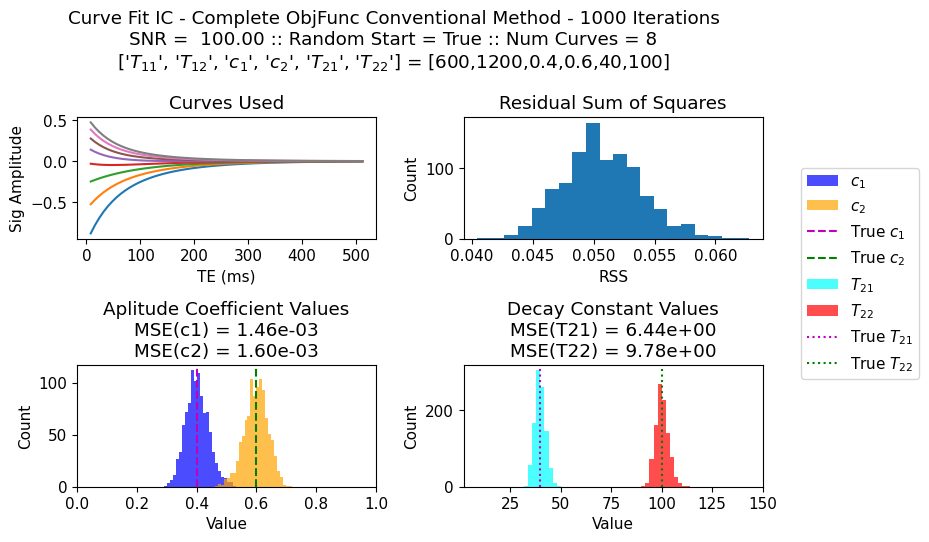

In [82]:
plt.rc('font', size = 11)

fig, ax = plt.subplots(2, 2, figsize=(8,5.5), tight_layout=True)
fig.suptitle(f"Curve Fit IC - Complete ObjFunc Conventional Method - {var_reps} Iterations\nSNR = {SNR_value : 0.2f} :: Random Start = {randStart} :: Num Curves = {len(TI_DATA)}\n{ParamTitle_6p} = [{T11},{T12},{c1},{c2},{T21},{T22}]")

labels = get_param_list(S_biX_6p)
lb, ub = get_func_bounds(S_biX_6p)

MSEMat, varMat, sqBMat = calc_MSE(param_est_cvn, true_params)

for ii in range(signal_array.shape[0]):
    ax[0,0].plot(TE_DATA, signal_array[ii,:])
# ax[0,0].legend()
ax[0,0].set_xlabel("TE (ms)")
ax[0,0].set_ylabel("Sig Amplitude")
ax[0,0].set_title("Curves Used")

ax[0,1].hist(x = fval_cvn, bins = 20)
ax[0,1].set_xlabel('RSS')
ax[0,1].set_ylabel('Count')
ax[0,1].set_title("Residual Sum of Squares")

bin_array = np.arange(0, 1, 0.01)
ax[1,0].hist(x=param_est_cvn[:,-4], bins=bin_array, color='b', label = r'$c_{1}$', alpha = 0.7)
ax[1,0].hist(x=param_est_cvn[:,-3], bins=bin_array, color='orange', label = r'$c_{2}$', alpha = 0.7)
ax[1,0].axvline(x = true_params[-4], label = r'True $c_{1}$', color='m', ls = '--')
ax[1,0].axvline(x = true_params[-3], label = r'True $c_{2}$', color='g', ls = '--')
# ax[1,0].legend()
ax[1,0].set_xlabel('Value')
ax[1,0].set_ylabel('Count')
ax[1,0].set_title(f"Aplitude Coefficient Values\nMSE(c1) = {MSEMat[-4]:.2e}\nMSE(c2) = {MSEMat[-3]:.2e}")
ax[1,0].set_xlim([lb[-3],ub[-3]])

bin_array = np.arange(0, ub[-1], 2)
bin_array = np.arange(0, ub[-1], 2)
ax[1,1].hist(x=param_est_cvn[:,-2], bins=bin_array, color='cyan', label = r'$T_{21}$', alpha = 0.7)
ax[1,1].hist(x=param_est_cvn[:,-1], bins=bin_array, color='red', label = r'$T_{22}$', alpha = 0.7)
ax[1,1].axvline(x = true_params[-2], label = r'True $T_{21}$', color='m', ls = ':')
ax[1,1].axvline(x = true_params[-1], label = r'True $T_{22}$', color='g', ls = ':')
# ax[1,1].legend()
ax[1,1].set_xlabel('Value')
ax[1,1].set_ylabel('Count')
ax[1,1].set_title(f"Decay Constant Values\nMSE(T21) = {MSEMat[-2]:.2e}\nMSE(T22) = {MSEMat[-1]:.2e}")
ax[1,1].set_xlim([lb[-1],ub[-1]])

fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

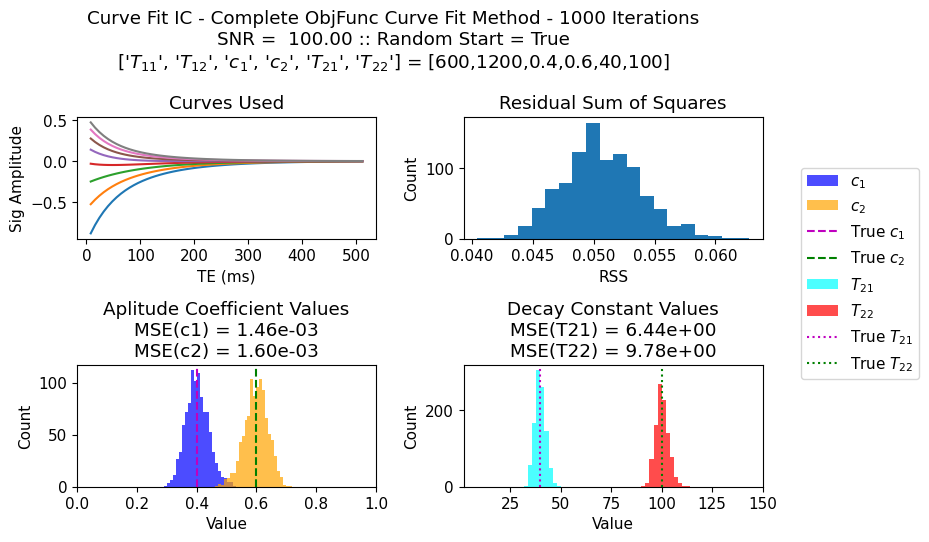

In [83]:
plt.rc('font', size = 11)

fig, ax = plt.subplots(2, 2, figsize=(8,5.5), tight_layout=True)
fig.suptitle(f"Curve Fit IC - Complete ObjFunc Curve Fit Method - {var_reps} Iterations\nSNR = {SNR_value : 0.2f} :: Random Start = {randStart}\n{ParamTitle_6p} = [{T11},{T12},{c1},{c2},{T21},{T22}]")

labels = get_param_list(S_biX_6p)
lb, ub = get_func_bounds(S_biX_6p)

MSEMat, varMat, sqBMat = calc_MSE(param_est_cF, true_params)

for ii in range(signal_array.shape[0]):
    ax[0,0].plot(TE_DATA, signal_array[ii,:])
# ax[0,0].legend()
ax[0,0].set_xlabel("TE (ms)")
ax[0,0].set_ylabel("Sig Amplitude")
ax[0,0].set_title("Curves Used")

ax[0,1].hist(x = fval_cF, bins = 20)
ax[0,1].set_xlabel('RSS')
ax[0,1].set_ylabel('Count')
ax[0,1].set_title("Residual Sum of Squares")

bin_array = np.arange(0, 1, 0.01)
ax[1,0].hist(x=param_est_cF[:,-4], bins=bin_array, color='b', label = r'$c_{1}$', alpha = 0.7)
ax[1,0].hist(x=param_est_cF[:,-3], bins=bin_array, color='orange', label = r'$c_{2}$', alpha = 0.7)
ax[1,0].axvline(x = true_params[-4], label = r'True $c_{1}$', color='m', ls = '--')
ax[1,0].axvline(x = true_params[-3], label = r'True $c_{2}$', color='g', ls = '--')
# ax[1,0].legend()
ax[1,0].set_xlabel('Value')
ax[1,0].set_ylabel('Count')
ax[1,0].set_title(f"Aplitude Coefficient Values\nMSE(c1) = {MSEMat[-4]:.2e}\nMSE(c2) = {MSEMat[-3]:.2e}")
ax[1,0].set_xlim([lb[-3],ub[-3]])

bin_array = np.arange(0, ub[-1], 2)
ax[1,1].hist(x=param_est_cF[:,-2], bins=bin_array, color='cyan', label = r'$T_{21}$', alpha = 0.7)
ax[1,1].hist(x=param_est_cF[:,-1], bins=bin_array, color='red', label = r'$T_{22}$', alpha = 0.7)
ax[1,1].axvline(x = true_params[-2], label = r'True $T_{21}$', color='m', ls = ':')
ax[1,1].axvline(x = true_params[-1], label = r'True $T_{22}$', color='g', ls = ':')
# ax[1,1].legend()
ax[1,1].set_xlabel('Value')
ax[1,1].set_ylabel('Count')
ax[1,1].set_title(f"Decay Constant Values\nMSE(T21) = {MSEMat[-2]:.2e}\nMSE(T22) = {MSEMat[-1]:.2e}")
ax[1,1].set_xlim([lb[-1],ub[-1]])

fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Presentation Figures

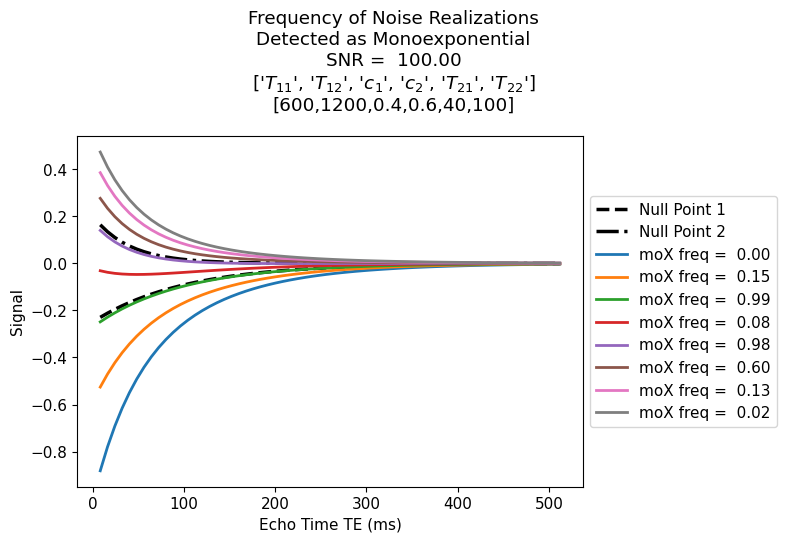

In [84]:
fig, ax = plt.subplots(1,1, figsize=(8,5.5), tight_layout=True)
fig.suptitle(f"Frequency of Noise Realizations\nDetected as Monoexponential\nSNR = {SNR_value : 0.2f}\n{ParamTitle_6p}\n[{T11},{T12},{c1},{c2},{T21},{T22}]")

ax.plot(TE_DATA, S_biX_6p(TE_DATA, *true_params, TI = TI1star), color = 'k', label = 'Null Point 1', lw = 2.5, ls = '--')
ax.plot(TE_DATA, S_biX_6p(TE_DATA, *true_params, TI = TI2star), color = 'k', label = 'Null Point 2', lw = 2.5, ls = '-.')
for iter in range(len(TI_DATA)):
    ax.plot(TE_DATA, signal_array[iter,:], lw = 2, label = f'moX freq = {BIC_moXassessments[iter]/var_reps: .2f}')

ax.set_xlabel('Echo Time TE (ms)')
ax.set_ylabel('Signal')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

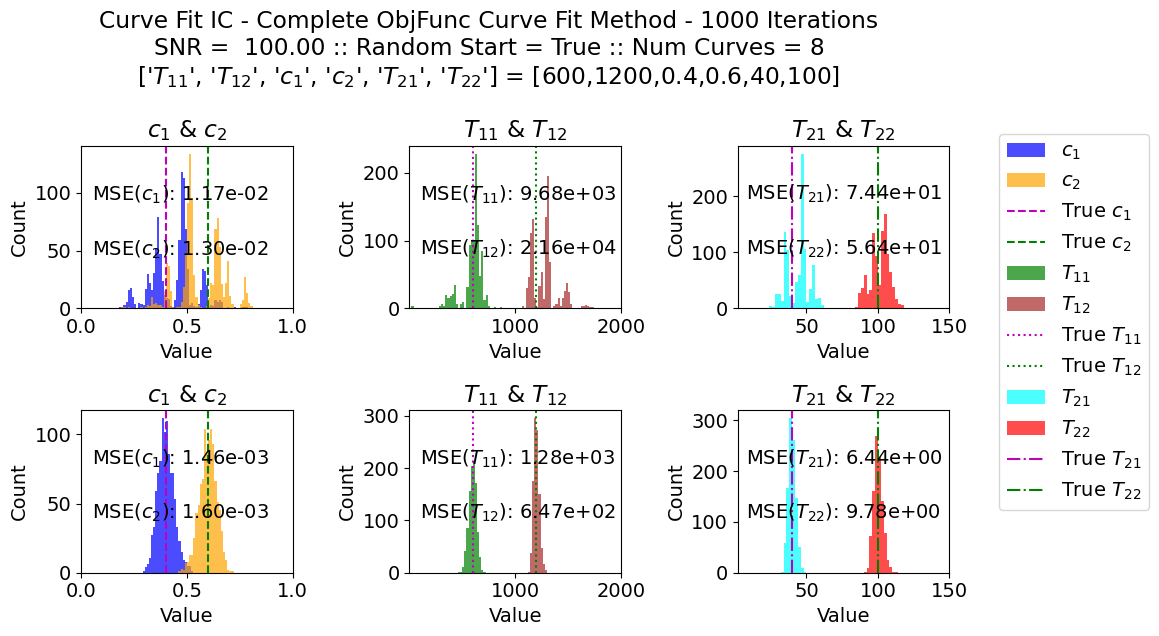

In [85]:
plt.rc('font', size = 14)

fig, ax = plt.subplots(2, 3, figsize=(10, 6.5), tight_layout=True)
fig.suptitle(f"Curve Fit IC - Complete ObjFunc Curve Fit Method - {var_reps} Iterations\nSNR = {SNR_value : 0.2f} :: Random Start = {randStart} :: Num Curves = {len(TI_DATA)}\n{ParamTitle_6p} = [{T11},{T12},{c1},{c2},{T21},{T22}]")

labels = get_param_list(S_biX_6p)
lb, ub = get_func_bounds(S_biX_6p)

MSEMat, varMat, sqBMat = calc_MSE(param_est_BIC, true_params)

bin_array = np.arange(0, 1, 0.01)
ax[0,0].hist(x=param_est_BIC[:,-4], bins=bin_array, color='b', alpha = 0.7)
ax[0,0].hist(x=param_est_BIC[:,-3], bins=bin_array, color='orange', alpha = 0.7)
ax[0,0].axvline(x = true_params[-4], color='m', ls = '--')
ax[0,0].axvline(x = true_params[-3], color='g', ls = '--')
ax[0,0].set_xlabel('Value')
ax[0,0].set_ylabel('Count')
ax[0,0].set_title(f"{ParamTitle_6p[-4]} & {ParamTitle_6p[-3]}")#\nMSE({ParamTitle_6p[-4]}) = {MSEMat[-4]:.2e}\nMSE({ParamTitle_6p[-3]}) = {MSEMat[-3]:.2e}")
ax[0,0].set_xlim([lb[-3],ub[-3]])
ymin, ymax = ax[0,0].get_ylim()
yup = ymin+(ymax-ymin)*2//3
ydn = ymin+(ymax-ymin)*1//3
ax[0,0].text(ub[-3]*0.05, yup, f"MSE({ParamTitle_6p[-4]}): {MSEMat[-4] :0.2e}", color = 'k')
ax[0,0].text(ub[-3]*0.05, ydn, f"MSE({ParamTitle_6p[-3]}): {MSEMat[-3] :0.2e}", color = 'k')

bin_array = np.arange(0, ub[1], 20)
ax[0,1].hist(x=param_est_BIC[:,0], bins=bin_array, color='g', alpha = 0.7)
ax[0,1].hist(x=param_est_BIC[:,1], bins=bin_array, color='brown', alpha = 0.7)
ax[0,1].axvline(x = true_params[0], color='m', ls = ':')
ax[0,1].axvline(x = true_params[1], color='g', ls = ':')
ax[0,1].set_xlabel('Value')
ax[0,1].set_ylabel('Count')
ax[0,1].set_title(f"{ParamTitle_6p[0]} & {ParamTitle_6p[1]}")#\nMSE({ParamTitle_6p[0]}) = {MSEMat[0]:.2e}\nMSE({ParamTitle_6p[1]}) = {MSEMat[1]:.2e}")
ax[0,1].set_xlim([lb[0],ub[0]])
ymin, ymax = ax[0,1].get_ylim()
yup = ymin+(ymax-ymin)*2//3
ydn = ymin+(ymax-ymin)*1//3
ax[0,1].text(ub[1]*0.05, yup, f"MSE({ParamTitle_6p[0]}): {MSEMat[0] :0.2e}", color = 'k')
ax[0,1].text(ub[1]*0.05, ydn, f"MSE({ParamTitle_6p[1]}): {MSEMat[1] :0.2e}", color = 'k')

bin_array = np.arange(0, ub[-1], 2)
ax[0,2].hist(x=param_est_BIC[:,-2], bins=bin_array, color='cyan', alpha = 0.7)
ax[0,2].hist(x=param_est_BIC[:,-1], bins=bin_array, color='red', alpha = 0.7)
ax[0,2].axvline(x = true_params[-2], color='m', ls = '-.')
ax[0,2].axvline(x = true_params[-1], color='g', ls = '-.')
ax[0,2].set_xlabel('Value')
ax[0,2].set_ylabel('Count')
ax[0,2].set_title(f"{ParamTitle_6p[-2]} & {ParamTitle_6p[-1]}")#\nMSE({ParamTitle_6p[-2]}) = {MSEMat[-2]:.2e}\nMSE({ParamTitle_6p[-1]}) = {MSEMat[-1]:.2e}")
ax[0,2].set_xlim([lb[-1],ub[-1]])
ymin, ymax = ax[0,2].get_ylim()
yup = ymin+(ymax-ymin)*2//3
ydn = ymin+(ymax-ymin)*1//3
ax[0,2].text(ub[-1]*0.05, yup, f"MSE({ParamTitle_6p[-2]}): {MSEMat[-2] :0.2e}", color = 'k')
ax[0,2].text(ub[-1]*0.05, ydn, f"MSE({ParamTitle_6p[-1]}): {MSEMat[-1] :0.2e}", color = 'k')


MSEMat, varMat, sqBMat = calc_MSE(param_est_cF, true_params)

bin_array = np.arange(0, 1, 0.01)
ax[1,0].hist(x=param_est_cF[:,-4], bins=bin_array, color='b', label = r'$c_{1}$', alpha = 0.7)
ax[1,0].hist(x=param_est_cF[:,-3], bins=bin_array, color='orange', label = r'$c_{2}$', alpha = 0.7)
ax[1,0].axvline(x = true_params[-4], label = r'True $c_{1}$', color='m', ls = '--')
ax[1,0].axvline(x = true_params[-3], label = r'True $c_{2}$', color='g', ls = '--')
ax[1,0].set_xlabel('Value')
ax[1,0].set_ylabel('Count')
ax[1,0].set_title(f"{ParamTitle_6p[-4]} & {ParamTitle_6p[-3]}")#\nMSE({ParamTitle_6p[-4]}) = {MSEMat[-4]:.2e}\nMSE({ParamTitle_6p[-3]}) = {MSEMat[-3]:.2e}")
ax[1,0].set_xlim([lb[-3],ub[-3]])
ymin, ymax = ax[1,0].get_ylim()
yup = ymin+(ymax-ymin)*2//3
ydn = ymin+(ymax-ymin)*1//3
ax[1,0].text(ub[-3]*0.05, yup, f"MSE({ParamTitle_6p[-4]}): {MSEMat[-4] :0.2e}", color = 'k')
ax[1,0].text(ub[-3]*0.05, ydn, f"MSE({ParamTitle_6p[-3]}): {MSEMat[-3] :0.2e}", color = 'k')

bin_array = np.arange(0, ub[1], 20)
ax[1,1].hist(x=param_est_cF[:,0], bins=bin_array, color='g', label = r'$T_{11}$', alpha = 0.7)
ax[1,1].hist(x=param_est_cF[:,1], bins=bin_array, color='brown', label = r'$T_{12}$', alpha = 0.7)
ax[1,1].axvline(x = true_params[0], label = r'True $T_{11}$', color='m', ls = ':')
ax[1,1].axvline(x = true_params[1], label = r'True $T_{12}$', color='g', ls = ':')
ax[1,1].set_xlabel('Value')
ax[1,1].set_ylabel('Count')
ax[1,1].set_title(f"{ParamTitle_6p[0]} & {ParamTitle_6p[1]}")#\nMSE({ParamTitle_6p[0]}) = {MSEMat[0]:.2e}\nMSE({ParamTitle_6p[1]}) = {MSEMat[1]:.2e}")
ax[1,1].set_xlim([lb[0],ub[0]])
ymin, ymax = ax[1,1].get_ylim()
yup = ymin+(ymax-ymin)*2//3
ydn = ymin+(ymax-ymin)*1//3
ax[1,1].text(ub[1]*0.05, yup, f"MSE({ParamTitle_6p[0]}): {MSEMat[0] :0.2e}", color = 'k')
ax[1,1].text(ub[1]*0.05, ydn, f"MSE({ParamTitle_6p[1]}): {MSEMat[1] :0.2e}", color = 'k')

bin_array = np.arange(0, ub[-1], 2)
ax[1,2].hist(x=param_est_cF[:,-2], bins=bin_array, color='cyan', label = r'$T_{21}$', alpha = 0.7)
ax[1,2].hist(x=param_est_cF[:,-1], bins=bin_array, color='red', label = r'$T_{22}$', alpha = 0.7)
ax[1,2].axvline(x = true_params[-2], label = r'True $T_{21}$', color='m', ls = '-.')
ax[1,2].axvline(x = true_params[-1], label = r'True $T_{22}$', color='g', ls = '-.')
ax[1,2].set_xlabel('Value')
ax[1,2].set_ylabel('Count')
ax[1,2].set_title(f"{ParamTitle_6p[-2]} & {ParamTitle_6p[-1]}")#\nMSE({ParamTitle_6p[-2]}) = {MSEMat[-2]:.2e}\nMSE({ParamTitle_6p[-1]}) = {MSEMat[-1]:.2e}")
ax[1,2].set_xlim([lb[-1],ub[-1]])
ymin, ymax = ax[1,2].get_ylim()
yup = ymin+(ymax-ymin)*2//3
ydn = ymin+(ymax-ymin)*1//3
ax[1,2].text(ub[-1]*0.05, yup, f"MSE({ParamTitle_6p[-2]}): {MSEMat[-2] :0.2e}", color = 'k')
ax[1,2].text(ub[-1]*0.05, ydn, f"MSE({ParamTitle_6p[-1]}): {MSEMat[-1] :0.2e}", color = 'k')

fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

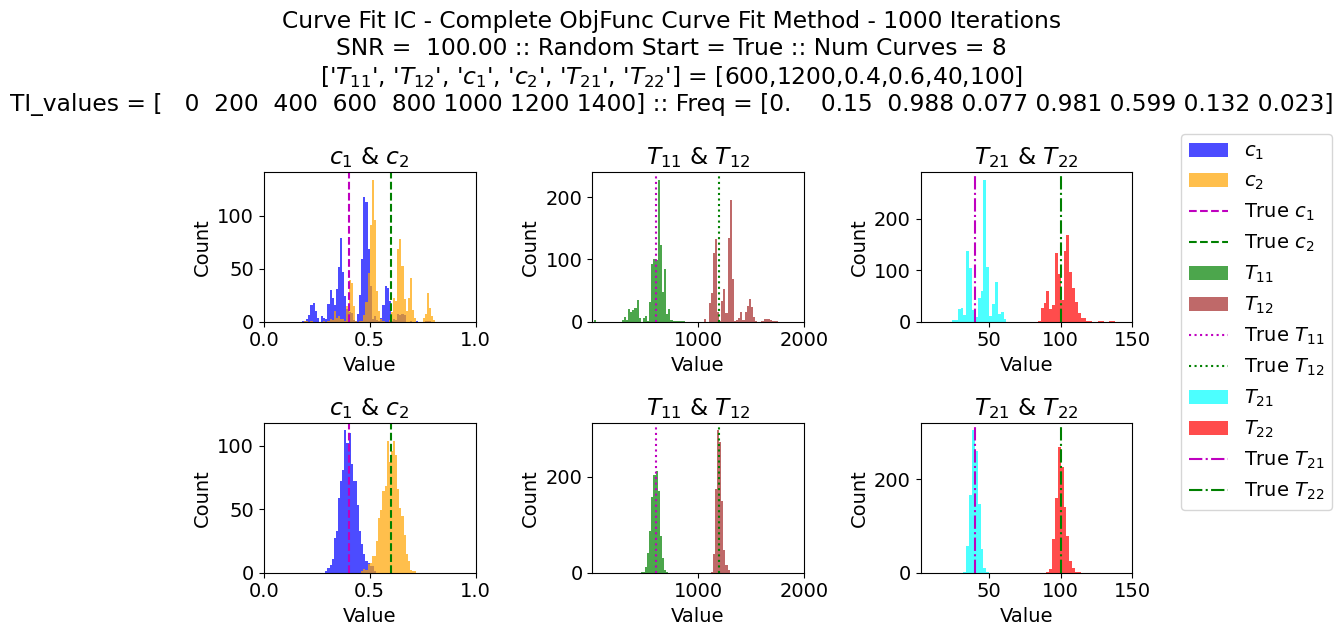

In [86]:
plt.rc('font', size = 14)

fig, ax = plt.subplots(2, 3, figsize=(10, 6.5), tight_layout=True)
fig.suptitle(f"Curve Fit IC - Complete ObjFunc Curve Fit Method - {var_reps} Iterations\nSNR = {SNR_value : 0.2f} :: Random Start = {randStart} :: Num Curves = {len(TI_DATA)}\n{ParamTitle_6p} = [{T11},{T12},{c1},{c2},{T21},{T22}]\nTI_values = {TI_DATA} :: Freq = {BIC_moXassessments/var_reps}")

labels = get_param_list(S_biX_6p)
lb, ub = get_func_bounds(S_biX_6p)

MSEMat, varMat, sqBMat = calc_MSE(param_est_BIC, true_params)

bin_array = np.arange(0, 1, 0.01)
ax[0,0].hist(x=param_est_BIC[:,-4], bins=bin_array, color='b', alpha = 0.7)
ax[0,0].hist(x=param_est_BIC[:,-3], bins=bin_array, color='orange', alpha = 0.7)
ax[0,0].axvline(x = true_params[-4], color='m', ls = '--')
ax[0,0].axvline(x = true_params[-3], color='g', ls = '--')
ax[0,0].set_xlabel('Value')
ax[0,0].set_ylabel('Count')
ax[0,0].set_title(f"{ParamTitle_6p[-4]} & {ParamTitle_6p[-3]}")#\nMSE({ParamTitle_6p[-4]}) = {MSEMat[-4]:.2e}\nMSE({ParamTitle_6p[-3]}) = {MSEMat[-3]:.2e}")
ax[0,0].set_xlim([lb[-3],ub[-3]])
# ymin, ymax = ax[0,0].get_ylim()
# yup = ymin+(ymax-ymin)*2//3
# ydn = ymin+(ymax-ymin)*1//3
# ax[0,0].text(ub[-3]*0.05, yup, f"MSE({ParamTitle_6p[-4]}): {MSEMat[-4] :0.2e}", color = 'k')
# ax[0,0].text(ub[-3]*0.05, ydn, f"MSE({ParamTitle_6p[-3]}): {MSEMat[-3] :0.2e}", color = 'k')

bin_array = np.arange(0, ub[1], 20)
ax[0,1].hist(x=param_est_BIC[:,0], bins=bin_array, color='g', alpha = 0.7)
ax[0,1].hist(x=param_est_BIC[:,1], bins=bin_array, color='brown', alpha = 0.7)
ax[0,1].axvline(x = true_params[0], color='m', ls = ':')
ax[0,1].axvline(x = true_params[1], color='g', ls = ':')
ax[0,1].set_xlabel('Value')
ax[0,1].set_ylabel('Count')
ax[0,1].set_title(f"{ParamTitle_6p[0]} & {ParamTitle_6p[1]}")#\nMSE({ParamTitle_6p[0]}) = {MSEMat[0]:.2e}\nMSE({ParamTitle_6p[1]}) = {MSEMat[1]:.2e}")
ax[0,1].set_xlim([lb[0],ub[0]])
# ymin, ymax = ax[0,1].get_ylim()
# yup = ymin+(ymax-ymin)*2//3
# ydn = ymin+(ymax-ymin)*1//3
# ax[0,1].text(ub[1]*0.05, yup, f"MSE({ParamTitle_6p[0]}): {MSEMat[0] :0.2e}", color = 'k')
# ax[0,1].text(ub[1]*0.05, ydn, f"MSE({ParamTitle_6p[1]}): {MSEMat[1] :0.2e}", color = 'k')

bin_array = np.arange(0, ub[-1], 2)
ax[0,2].hist(x=param_est_BIC[:,-2], bins=bin_array, color='cyan', alpha = 0.7)
ax[0,2].hist(x=param_est_BIC[:,-1], bins=bin_array, color='red', alpha = 0.7)
ax[0,2].axvline(x = true_params[-2], color='m', ls = '-.')
ax[0,2].axvline(x = true_params[-1], color='g', ls = '-.')
ax[0,2].set_xlabel('Value')
ax[0,2].set_ylabel('Count')
ax[0,2].set_title(f"{ParamTitle_6p[-2]} & {ParamTitle_6p[-1]}")#\nMSE({ParamTitle_6p[-2]}) = {MSEMat[-2]:.2e}\nMSE({ParamTitle_6p[-1]}) = {MSEMat[-1]:.2e}")
ax[0,2].set_xlim([lb[-1],ub[-1]])
# ymin, ymax = ax[0,2].get_ylim()
# yup = ymin+(ymax-ymin)*2//3
# ydn = ymin+(ymax-ymin)*1//3
# ax[0,2].text(ub[-1]*0.05, yup, f"MSE({ParamTitle_6p[-2]}): {MSEMat[-2] :0.2e}", color = 'k')
# ax[0,2].text(ub[-1]*0.05, ydn, f"MSE({ParamTitle_6p[-1]}): {MSEMat[-1] :0.2e}", color = 'k')


MSEMat, varMat, sqBMat = calc_MSE(param_est_cF, true_params)

bin_array = np.arange(0, 1, 0.01)
ax[1,0].hist(x=param_est_cF[:,-4], bins=bin_array, color='b', label = r'$c_{1}$', alpha = 0.7)
ax[1,0].hist(x=param_est_cF[:,-3], bins=bin_array, color='orange', label = r'$c_{2}$', alpha = 0.7)
ax[1,0].axvline(x = true_params[-4], label = r'True $c_{1}$', color='m', ls = '--')
ax[1,0].axvline(x = true_params[-3], label = r'True $c_{2}$', color='g', ls = '--')
ax[1,0].set_xlabel('Value')
ax[1,0].set_ylabel('Count')
ax[1,0].set_title(f"{ParamTitle_6p[-4]} & {ParamTitle_6p[-3]}")#\nMSE({ParamTitle_6p[-4]}) = {MSEMat[-4]:.2e}\nMSE({ParamTitle_6p[-3]}) = {MSEMat[-3]:.2e}")
ax[1,0].set_xlim([lb[-3],ub[-3]])
# ymin, ymax = ax[1,0].get_ylim()
# yup = ymin+(ymax-ymin)*2//3
# ydn = ymin+(ymax-ymin)*1//3
# ax[1,0].text(ub[-3]*0.05, yup, f"MSE({ParamTitle_6p[-4]}): {MSEMat[-4] :0.2e}", color = 'k')
# ax[1,0].text(ub[-3]*0.05, ydn, f"MSE({ParamTitle_6p[-3]}): {MSEMat[-3] :0.2e}", color = 'k')

bin_array = np.arange(0, ub[1], 20)
ax[1,1].hist(x=param_est_cF[:,0], bins=bin_array, color='g', label = r'$T_{11}$', alpha = 0.7)
ax[1,1].hist(x=param_est_cF[:,1], bins=bin_array, color='brown', label = r'$T_{12}$', alpha = 0.7)
ax[1,1].axvline(x = true_params[0], label = r'True $T_{11}$', color='m', ls = ':')
ax[1,1].axvline(x = true_params[1], label = r'True $T_{12}$', color='g', ls = ':')
ax[1,1].set_xlabel('Value')
ax[1,1].set_ylabel('Count')
ax[1,1].set_title(f"{ParamTitle_6p[0]} & {ParamTitle_6p[1]}")#\nMSE({ParamTitle_6p[0]}) = {MSEMat[0]:.2e}\nMSE({ParamTitle_6p[1]}) = {MSEMat[1]:.2e}")
ax[1,1].set_xlim([lb[0],ub[0]])
# ymin, ymax = ax[1,1].get_ylim()
# yup = ymin+(ymax-ymin)*2//3
# ydn = ymin+(ymax-ymin)*1//3
# ax[1,1].text(ub[1]*0.05, yup, f"MSE({ParamTitle_6p[0]}): {MSEMat[0] :0.2e}", color = 'k')
# ax[1,1].text(ub[1]*0.05, ydn, f"MSE({ParamTitle_6p[1]}): {MSEMat[1] :0.2e}", color = 'k')

bin_array = np.arange(0, ub[-1], 2)
ax[1,2].hist(x=param_est_cF[:,-2], bins=bin_array, color='cyan', label = r'$T_{21}$', alpha = 0.7)
ax[1,2].hist(x=param_est_cF[:,-1], bins=bin_array, color='red', label = r'$T_{22}$', alpha = 0.7)
ax[1,2].axvline(x = true_params[-2], label = r'True $T_{21}$', color='m', ls = '-.')
ax[1,2].axvline(x = true_params[-1], label = r'True $T_{22}$', color='g', ls = '-.')
ax[1,2].set_xlabel('Value')
ax[1,2].set_ylabel('Count')
ax[1,2].set_title(f"{ParamTitle_6p[-2]} & {ParamTitle_6p[-1]}")#\nMSE({ParamTitle_6p[-2]}) = {MSEMat[-2]:.2e}\nMSE({ParamTitle_6p[-1]}) = {MSEMat[-1]:.2e}")
ax[1,2].set_xlim([lb[-1],ub[-1]])
# ymin, ymax = ax[1,2].get_ylim()
# yup = ymin+(ymax-ymin)*2//3
# ydn = ymin+(ymax-ymin)*1//3
# ax[1,2].text(ub[-1]*0.05, yup, f"MSE({ParamTitle_6p[-2]}): {MSEMat[-2] :0.2e}", color = 'k')
# ax[1,2].text(ub[-1]*0.05, ydn, f"MSE({ParamTitle_6p[-1]}): {MSEMat[-1] :0.2e}", color = 'k')

fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

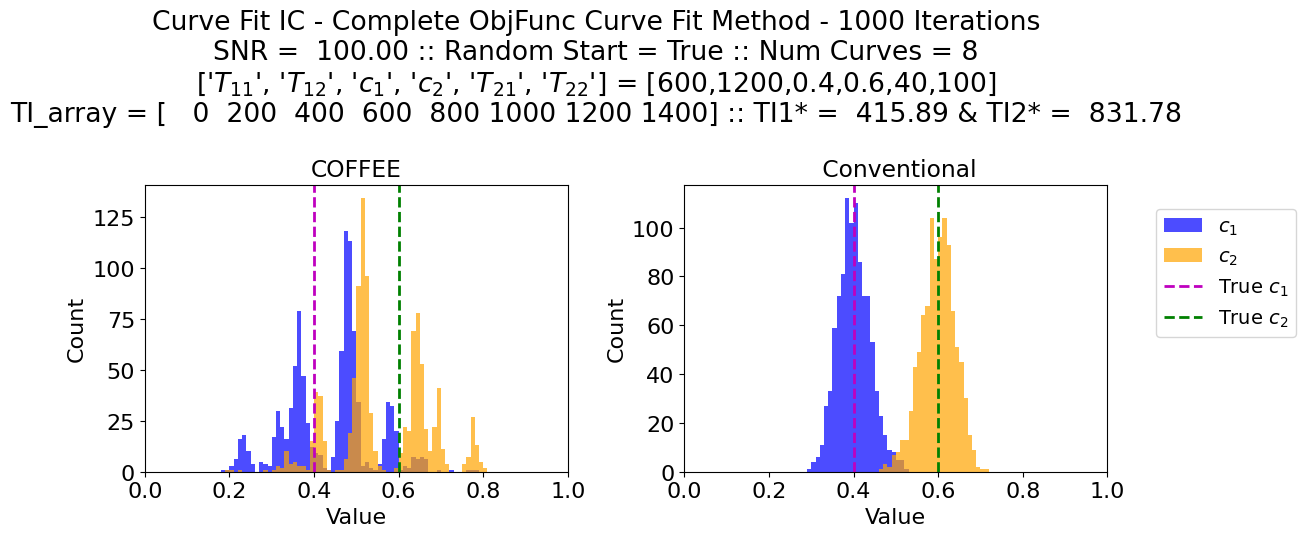

In [87]:
plt.rc('font', size = 16)

fig, ax = plt.subplots(1, 2, figsize=(11, 5.5), tight_layout=True)
fig.suptitle(f"Curve Fit IC - Complete ObjFunc Curve Fit Method - {var_reps} Iterations\nSNR = {SNR_value : 0.2f} :: Random Start = {randStart} :: Num Curves = {len(TI_DATA)}\n{ParamTitle_6p} = [{T11},{T12},{c1},{c2},{T21},{T22}]\nTI_array = {TI_DATA} :: TI1* = {TI1star: .2f} & TI2* = {TI2star: .2f}")

plt.rc('font', size = 14)

labels = get_param_list(S_biX_6p)
lb, ub = get_func_bounds(S_biX_6p)

MSEMat, varMat, sqBMat = calc_MSE(param_est_BIC, true_params)

bin_array = np.arange(0, 1, 0.01)
ax[0].hist(x=param_est_BIC[:,-4], bins=bin_array, color='b', alpha = 0.7)
ax[0].hist(x=param_est_BIC[:,-3], bins=bin_array, color='orange', alpha = 0.7)
ax[0].axvline(x = true_params[-4], color='m', ls = '--', lw = 2)
ax[0].axvline(x = true_params[-3], color='g', ls = '--', lw = 2)
ax[0].set_xlabel('Value')
ax[0].set_ylabel('Count')
ax[0].set_title(f"COFFEE")#\nMSE({ParamTitle_6p[-4]}) = {MSEMat[-4]:.2e}\nMSE({ParamTitle_6p[-3]}) = {MSEMat[-3]:.2e}")
ax[0].set_xlim([lb[-3],ub[-3]])


MSEMat, varMat, sqBMat = calc_MSE(param_est_cF, true_params)

bin_array = np.arange(0, 1, 0.01)
ax[1].hist(x=param_est_cF[:,-4], bins=bin_array, color='b', label = r'$c_{1}$', alpha = 0.7)
ax[1].hist(x=param_est_cF[:,-3], bins=bin_array, color='orange', label = r'$c_{2}$', alpha = 0.7)
ax[1].axvline(x = true_params[-4], label = r'True $c_{1}$', color='m', ls = '--', lw = 2)
ax[1].axvline(x = true_params[-3], label = r'True $c_{2}$', color='g', ls = '--', lw = 2)
ax[1].set_xlabel('Value')
ax[1].set_ylabel('Count')
ax[1].set_title(f" Conventional")#\nMSE({ParamTitle_6p[-4]}) = {MSEMat[-4]:.2e}\nMSE({ParamTitle_6p[-3]}) = {MSEMat[-3]:.2e}")
ax[1].set_xlim([lb[-3],ub[-3]])

fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [88]:
MSEMat, varMat, biasMat = calc_MSE(param_est_BIC, true_params)

print(f'COFFEE:')
print(f'MSE(c_1) = {MSEMat[-4]: .2e} & MSE(c_2) = {MSEMat[-3]: .2e}')
print(f'var(c_1) = {varMat[-4]: .2e} & var(c_2) = {varMat[-3]: .2e}')

print(f'---------------------------------------------------------')

MSEMat, varMat, sqBMat = calc_MSE(param_est_cvn, true_params)

print(f'\nConventional Filtered:')
print(f'MSE(c_1) = {MSEMat[-4]: .2e} & MSE(c_2) = {MSEMat[-3]: .2e}')
print(f'var(c_1) = {varMat[-4]: .2e} & var(c_2) = {varMat[-3]: .2e}')

COFFEE:
MSE(c_1) =  1.17e-02 & MSE(c_2) =  1.30e-02
var(c_1) =  1.03e-02 & var(c_2) =  1.15e-02
---------------------------------------------------------

Conventional Filtered:
MSE(c_1) =  1.46e-03 & MSE(c_2) =  1.60e-03
var(c_1) =  1.46e-03 & var(c_2) =  1.60e-03
